[View in Colaboratory](https://colab.research.google.com/github/ozanpekmezci/capstone/blob/master/multi_digit_recognition.ipynb)

# Multi Digit Number Recognition

This project implements multi digit number recognition that will be used to recognize house numbers at the streets. Keras and Tensorflow libraries are used to build the recognizer.
This recognizer extracts digit from the image using Convolutional Neural Network Classifier.

In [0]:
# Module Imports
from __future__ import print_function
import random
from os import listdir
import glob

import numpy as np
from scipy import misc
import tensorflow as tf
import h5py

from keras.datasets import mnist
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
# Setting the random seed so that the results are reproducible. 
random.seed(42)

# Setting variables for MNIST image dimensions
mnist_image_height = 28
mnist_image_width = 28

In [0]:
# Import MNIST data from keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


Shape of training dataset: (60000, 28, 28)
Shape of test dataset: (10000, 28, 28)
Label for image: 5


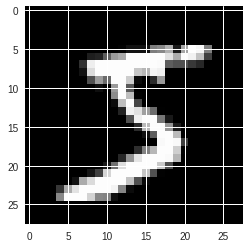

In [0]:
#Checking the downloaded data
print("Shape of training dataset: {}".format(np.shape(X_train)))
print("Shape of test dataset: {}".format(np.shape(X_test)))


plt.figure()
plt.imshow(X_train[0], cmap='gray')

print("Label for image: {}".format(y_train[0]))

## Building a new dataset
This method builds a new synthetic dataset that stitches multiple digits together. Labels and data can contain numbers from 0 to 9 including the blank character for shorter house numbers. The length is preset to be always 5.

In [0]:
def build_synth_data(data, labels, dataset_size):
    
    # Define synthetic image dimensions
    synth_img_height = 64
    synth_img_width = 64
    
    # Define synthetic data
    synth_data = np.ndarray(shape=(dataset_size, synth_img_height,
                                   synth_img_width), dtype=np.float32)
    
    # Define synthetic labels
    synth_labels = [] 
    
    # For a loop till the size of the synthetic dataset
    for i in range(0,dataset_size):
        
        # Pick a random number of digits to be in the dataset
        num_digits = random.randint(1,5)
        
        # Randomly sampling indices to extract digits + labels afterwards
        s_indices = [random.randint(0, len(data)-1) for p in range(0, num_digits)]
        
        # stitch images together
        new_image = np.hstack([X_train[index] for index in s_indices])
        # stitch the labels together
        new_label =  [y_train[index] for index in s_indices]
        
        
        # Loop till number of digits - 5, to concatenate blanks images, and blank labels together
        for j in range(0,5-num_digits):
            new_image = np.hstack([new_image, np.zeros(shape=(mnist_image_height,
                                                                   mnist_image_width))])
            new_label.append(10) #Might need to remove this step
        
        # Resize image
        new_image = misc.imresize(new_image,(64,64))
        
        # Assign the image to synth_data
        synth_data[i,:,:] = new_image
        
        # Assign the label to synth_data
        synth_labels.append(tuple(new_label))
        
    
    # Return the synthetic dataset
    return synth_data,synth_labels

In [0]:
# Building the training dataset
X_synth_train, y_synth_train = build_synth_data(X_train, y_train, 60000)

/usr/local/lib/python2.7/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python2.7/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [0]:
# Building the test dataset
X_synth_test, y_synth_test = build_synth_data(X_test, y_test, 10000)

(7, 3, 1, 1, 3)

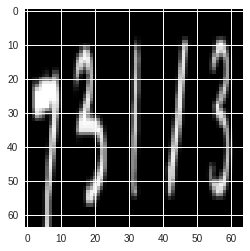

In [0]:
# checking a sample
plt.figure()
plt.imshow(X_synth_train[232], cmap='gray')

y_synth_train[232]

## Convert Labels
This function converts each digit label to one-hot array.

In [0]:
# Converting labels to One-hot representations of shape (set_size, digits, classes)
possible_classes = 11

def convert_labels(labels):
    
    # As per Keras conventions, the multiple labels need to be of the form [array_digit1,...5]
    # Each digit array will be of shape (60000,11)
        
    # Declare output ndarrays
    # 5 for digits, 11 for possible classes  
    dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig1_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig2_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig3_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig4_arr = np.ndarray(shape=(len(labels),possible_classes))
    
    for index,label in enumerate(labels):
        
        # Using np_utils from keras to OHE the labels in the image
        dig0_arr[index,:] = np_utils.to_categorical(label[0],possible_classes)
        dig1_arr[index,:] = np_utils.to_categorical(label[1],possible_classes)
        dig2_arr[index,:] = np_utils.to_categorical(label[2],possible_classes)
        dig3_arr[index,:] = np_utils.to_categorical(label[3],possible_classes)
        dig4_arr[index,:] = np_utils.to_categorical(label[4],possible_classes)
        
    return [dig0_arr,dig1_arr,dig2_arr,dig3_arr,dig4_arr]

In [0]:
train_labels = convert_labels(y_synth_train)
test_labels = convert_labels(y_synth_test)

In [0]:
# Checking the shape of the OHE array for the first digit position
np.shape(train_labels[0])

(60000, 11)

In [0]:
np_utils.to_categorical(y_synth_train[234][0],11)

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Prepare Data for Keras
Reshape image data to be processed by Keras.

In [0]:
def prep_data_keras(img_data):
    
    # Reshaping data for keras, with tensorflow as backend
    img_data = img_data.reshape(len(img_data), 64, 64, 1)
    
    # Converting everything to floats
    img_data = img_data.astype('float32')
    
    # Normalizing values between 0 and 1
    img_data /= 255
    
    return img_data


In [0]:
train_images = prep_data_keras(X_synth_train)
test_images = prep_data_keras(X_synth_test)

In [0]:
np.shape(train_images)

(60000, 64, 64, 1)

In [0]:
np.shape(test_images)

(10000, 64, 64, 1)

In [0]:
# Importing relevant keras modules
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

## Build Model
Build Deep Learning model to process data.

In [0]:
# Building the model

batch_size = 128
nb_classes = 11
nb_epoch = 12

# image input dimensions
img_rows = 64
img_cols = 64
img_channels = 1

# number of convulation filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# defining the input
inputs = Input(shape=(img_rows, img_cols, img_channels))

# Model taken from keras example.
cov = Convolution2D(nb_filters,kernel_size[0],kernel_size[1],border_mode='same')(inputs)
cov = Activation('relu')(cov)
cov = Convolution2D(nb_filters,kernel_size[0],kernel_size[1])(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.25)(cov)
cov_out = Flatten()(cov)


# Dense Layers
cov2 = Dense(128, activation='relu')(cov_out)
cov2 = Dropout(0.5)(cov2)



# Prediction layers
c0 = Dense(nb_classes, activation='softmax')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)

# Defining the model
model = Model(input=inputs,output=[c0,c1,c2,c3,c4])

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Fitting the model
model.fit(train_images,train_labels,batch_size=batch_size,nb_epoch=nb_epoch,verbose=1,
          validation_data=(test_images, test_labels))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/12
35328/60000 [================>.............] - ETA: 15s - loss: 4.7782 - dense_2_loss: 1.2430 - dense_3_loss: 1.1536 - dense_4_loss: 1.0117 - dense_5_loss: 0.8192 - dense_6_loss: 0.5507 - dense_2_acc: 0.5798 - dense_3_acc: 0.6191 - dense_4_acc: 0.6711 - dense_5_acc: 0.7370 - dense_6_acc: 0.8305

60000/60000 [==============================] - 37s 616us/step - loss: 4.0969 - dense_2_loss: 1.0501 - dense_3_loss: 0.9812 - dense_4_loss: 0.8666 - dense_5_loss: 0.7132 - dense_6_loss: 0.4857 - dense_2_acc: 0.6463 - dense_3_acc: 0.6756 - dense_4_acc: 0.7163 - dense_5_acc: 0.7689 - dense_6_acc: 0.8481 - val_loss: 1.2074 - val_dense_2_loss: 0.2849 - val_dense_3_loss: 0.2704 - val_dense_4_loss: 0.2261 - val_dense_5_loss: 0.2283 - val_dense_6_loss: 0.1976 - val_dense_2_acc: 0.9402 - val_dense_3_acc: 0.9431 - val_dense_4_acc: 0.9533 - val_dense_5_acc: 0.9530 - val_dense_6_acc: 0.9452
Epoch 2/12
 6016/60000 [==>...........................] - ETA: 29s - loss: 2.8553 - dense_2_loss: 0.7158 - dense_3_loss: 0.6799 - dense_4_loss: 0.6063 - dense_5_loss: 0.5087 - dense_6_loss: 0.3446 - dense_2_acc: 0.7581 - dense_3_acc: 0.7723 - dense_4_acc: 0.7967 - dense_5_acc: 0.8333 - dense_6_acc: 0.8901

47616/60000 [======================>.......] - ETA: 6s - loss: 2.6638 - dense_2_loss: 0.6536 - dense_3_loss: 0.6241 - dense_4_loss: 0.5701 - dense_5_loss: 0.4816 - dense_6_loss: 0.3343 - dense_2_acc: 0.7814 - dense_3_acc: 0.7895 - dense_4_acc: 0.8090 - dense_5_acc: 0.8389 - dense_6_acc: 0.8906

60000/60000 [==============================] - 34s 567us/step - loss: 2.6194 - dense_2_loss: 0.6402 - dense_3_loss: 0.6118 - dense_4_loss: 0.5643 - dense_5_loss: 0.4736 - dense_6_loss: 0.3295 - dense_2_acc: 0.7855 - dense_3_acc: 0.7926 - dense_4_acc: 0.8112 - dense_5_acc: 0.8414 - dense_6_acc: 0.8922 - val_loss: 0.8173 - val_dense_2_loss: 0.1923 - val_dense_3_loss: 0.1750 - val_dense_4_loss: 0.1563 - val_dense_5_loss: 0.1576 - val_dense_6_loss: 0.1362 - val_dense_2_acc: 0.9554 - val_dense_3_acc: 0.9614 - val_dense_4_acc: 0.9664 - val_dense_5_acc: 0.9687 - val_dense_6_acc: 0.9662
Epoch 3/12
 9600/60000 [===>..........................] - ETA: 27s - loss: 2.3345 - dense_2_loss: 0.5643 - dense_3_loss: 0.5413 - dense_4_loss: 0.4896 - dense_5_loss: 0.4292 - dense_6_loss: 0.3101 - dense_2_acc: 0.8073 - dense_3_acc: 0.8173 - dense_4_acc: 0.8342 - dense_5_acc: 0.8553 - dense_6_acc: 0.8992

51584/60000 [========================>.....] - ETA: 4s - loss: 2.2637 - dense_2_loss: 0.5417 - dense_3_loss: 0.5170 - dense_4_loss: 0.4898 - dense_5_loss: 0.4218 - dense_6_loss: 0.2933 - dense_2_acc: 0.8175 - dense_3_acc: 0.8261 - dense_4_acc: 0.8346 - dense_5_acc: 0.8579 - dense_6_acc: 0.9025

60000/60000 [==============================] - 34s 570us/step - loss: 2.2489 - dense_2_loss: 0.5361 - dense_3_loss: 0.5121 - dense_4_loss: 0.4887 - dense_5_loss: 0.4213 - dense_6_loss: 0.2908 - dense_2_acc: 0.8194 - dense_3_acc: 0.8280 - dense_4_acc: 0.8348 - dense_5_acc: 0.8583 - dense_6_acc: 0.9031 - val_loss: 0.6751 - val_dense_2_loss: 0.1500 - val_dense_3_loss: 0.1338 - val_dense_4_loss: 0.1334 - val_dense_5_loss: 0.1413 - val_dense_6_loss: 0.1165 - val_dense_2_acc: 0.9634 - val_dense_3_acc: 0.9669 - val_dense_4_acc: 0.9711 - val_dense_5_acc: 0.9715 - val_dense_6_acc: 0.9731
Epoch 4/12
11136/60000 [====>.........................] - ETA: 25s - loss: 2.0683 - dense_2_loss: 0.4793 - dense_3_loss: 0.4581 - dense_4_loss: 0.4468 - dense_5_loss: 0.4101 - dense_6_loss: 0.2740 - dense_2_acc: 0.8384 - dense_3_acc: 0.8434 - dense_4_acc: 0.8463 - dense_5_acc: 0.8617 - dense_6_acc: 0.9060

53632/60000 [=========================>....] - ETA: 3s - loss: 2.0173 - dense_2_loss: 0.4715 - dense_3_loss: 0.4509 - dense_4_loss: 0.4393 - dense_5_loss: 0.3858 - dense_6_loss: 0.2697 - dense_2_acc: 0.8386 - dense_3_acc: 0.8474 - dense_4_acc: 0.8510 - dense_5_acc: 0.8677 - dense_6_acc: 0.9090

60000/60000 [==============================] - 34s 567us/step - loss: 2.0120 - dense_2_loss: 0.4698 - dense_3_loss: 0.4497 - dense_4_loss: 0.4372 - dense_5_loss: 0.3861 - dense_6_loss: 0.2692 - dense_2_acc: 0.8400 - dense_3_acc: 0.8475 - dense_4_acc: 0.8513 - dense_5_acc: 0.8674 - dense_6_acc: 0.9092 - val_loss: 0.5894 - val_dense_2_loss: 0.1313 - val_dense_3_loss: 0.1168 - val_dense_4_loss: 0.1128 - val_dense_5_loss: 0.1227 - val_dense_6_loss: 0.1058 - val_dense_2_acc: 0.9658 - val_dense_3_acc: 0.9707 - val_dense_4_acc: 0.9741 - val_dense_5_acc: 0.9741 - val_dense_6_acc: 0.9747
Epoch 5/12
12032/60000 [=====>........................] - ETA: 26s - loss: 1.8811 - dense_2_loss: 0.4374 - dense_3_loss: 0.4124 - dense_4_loss: 0.4062 - dense_5_loss: 0.3631 - dense_6_loss: 0.2620 - dense_2_acc: 0.8509 - dense_3_acc: 0.8614 - dense_4_acc: 0.8587 - dense_5_acc: 0.8738 - dense_6_acc: 0.9096

54272/60000 [==========================>...] - ETA: 3s - loss: 1.8484 - dense_2_loss: 0.4263 - dense_3_loss: 0.4007 - dense_4_loss: 0.4057 - dense_5_loss: 0.3596 - dense_6_loss: 0.2562 - dense_2_acc: 0.8535 - dense_3_acc: 0.8626 - dense_4_acc: 0.8597 - dense_5_acc: 0.8762 - dense_6_acc: 0.9120

60000/60000 [==============================] - 34s 574us/step - loss: 1.8386 - dense_2_loss: 0.4233 - dense_3_loss: 0.3996 - dense_4_loss: 0.4040 - dense_5_loss: 0.3573 - dense_6_loss: 0.2545 - dense_2_acc: 0.8540 - dense_3_acc: 0.8628 - dense_4_acc: 0.8604 - dense_5_acc: 0.8769 - dense_6_acc: 0.9126 - val_loss: 0.5186 - val_dense_2_loss: 0.1207 - val_dense_3_loss: 0.1016 - val_dense_4_loss: 0.0968 - val_dense_5_loss: 0.1031 - val_dense_6_loss: 0.0964 - val_dense_2_acc: 0.9674 - val_dense_3_acc: 0.9743 - val_dense_4_acc: 0.9771 - val_dense_5_acc: 0.9771 - val_dense_6_acc: 0.9764
Epoch 6/12
11904/60000 [====>.........................] - ETA: 26s - loss: 1.7117 - dense_2_loss: 0.3908 - dense_3_loss: 0.3745 - dense_4_loss: 0.3675 - dense_5_loss: 0.3397 - dense_6_loss: 0.2392 - dense_2_acc: 0.8635 - dense_3_acc: 0.8702 - dense_4_acc: 0.8694 - dense_5_acc: 0.8802 - dense_6_acc: 0.9174

54400/60000 [==========================>...] - ETA: 3s - loss: 1.6747 - dense_2_loss: 0.3748 - dense_3_loss: 0.3644 - dense_4_loss: 0.3661 - dense_5_loss: 0.3320 - dense_6_loss: 0.2374 - dense_2_acc: 0.8683 - dense_3_acc: 0.8731 - dense_4_acc: 0.8722 - dense_5_acc: 0.8840 - dense_6_acc: 0.9174

60000/60000 [==============================] - 34s 574us/step - loss: 1.6724 - dense_2_loss: 0.3749 - dense_3_loss: 0.3629 - dense_4_loss: 0.3658 - dense_5_loss: 0.3309 - dense_6_loss: 0.2379 - dense_2_acc: 0.8680 - dense_3_acc: 0.8742 - dense_4_acc: 0.8719 - dense_5_acc: 0.8846 - dense_6_acc: 0.9173 - val_loss: 0.4553 - val_dense_2_loss: 0.1049 - val_dense_3_loss: 0.0816 - val_dense_4_loss: 0.0828 - val_dense_5_loss: 0.0934 - val_dense_6_loss: 0.0926 - val_dense_2_acc: 0.9710 - val_dense_3_acc: 0.9779 - val_dense_4_acc: 0.9775 - val_dense_5_acc: 0.9781 - val_dense_6_acc: 0.9779
Epoch 7/12
12032/60000 [=====>........................] - ETA: 26s - loss: 1.5421 - dense_2_loss: 0.3443 - dense_3_loss: 0.3400 - dense_4_loss: 0.3287 - dense_5_loss: 0.3078 - dense_6_loss: 0.2212 - dense_2_acc: 0.8777 - dense_3_acc: 0.8807 - dense_4_acc: 0.8834 - dense_5_acc: 0.8883 - dense_6_acc: 0.9221

55296/60000 [==========================>...] - ETA: 2s - loss: 1.5459 - dense_2_loss: 0.3471 - dense_3_loss: 0.3345 - dense_4_loss: 0.3365 - dense_5_loss: 0.3042 - dense_6_loss: 0.2237 - dense_2_acc: 0.8768 - dense_3_acc: 0.8822 - dense_4_acc: 0.8799 - dense_5_acc: 0.8925 - dense_6_acc: 0.9216

60000/60000 [==============================] - 34s 571us/step - loss: 1.5449 - dense_2_loss: 0.3471 - dense_3_loss: 0.3348 - dense_4_loss: 0.3358 - dense_5_loss: 0.3035 - dense_6_loss: 0.2238 - dense_2_acc: 0.8769 - dense_3_acc: 0.8818 - dense_4_acc: 0.8801 - dense_5_acc: 0.8924 - dense_6_acc: 0.9212 - val_loss: 0.4130 - val_dense_2_loss: 0.0956 - val_dense_3_loss: 0.0761 - val_dense_4_loss: 0.0727 - val_dense_5_loss: 0.0853 - val_dense_6_loss: 0.0834 - val_dense_2_acc: 0.9743 - val_dense_3_acc: 0.9804 - val_dense_4_acc: 0.9802 - val_dense_5_acc: 0.9792 - val_dense_6_acc: 0.9807
Epoch 8/12
12672/60000 [=====>........................] - ETA: 25s - loss: 1.4605 - dense_2_loss: 0.3275 - dense_3_loss: 0.3227 - dense_4_loss: 0.3153 - dense_5_loss: 0.2889 - dense_6_loss: 0.2061 - dense_2_acc: 0.8845 - dense_3_acc: 0.8843 - dense_4_acc: 0.8847 - dense_5_acc: 0.8976 - dense_6_acc: 0.9268

53888/60000 [=========================>....] - ETA: 3s - loss: 1.4408 - dense_2_loss: 0.3236 - dense_3_loss: 0.3122 - dense_4_loss: 0.3120 - dense_5_loss: 0.2859 - dense_6_loss: 0.2072 - dense_2_acc: 0.8834 - dense_3_acc: 0.8884 - dense_4_acc: 0.8879 - dense_5_acc: 0.8978 - dense_6_acc: 0.9264

60000/60000 [==============================] - 34s 570us/step - loss: 1.4404 - dense_2_loss: 0.3222 - dense_3_loss: 0.3125 - dense_4_loss: 0.3135 - dense_5_loss: 0.2849 - dense_6_loss: 0.2072 - dense_2_acc: 0.8841 - dense_3_acc: 0.8886 - dense_4_acc: 0.8876 - dense_5_acc: 0.8980 - dense_6_acc: 0.9262 - val_loss: 0.3865 - val_dense_2_loss: 0.0895 - val_dense_3_loss: 0.0713 - val_dense_4_loss: 0.0683 - val_dense_5_loss: 0.0829 - val_dense_6_loss: 0.0746 - val_dense_2_acc: 0.9739 - val_dense_3_acc: 0.9813 - val_dense_4_acc: 0.9821 - val_dense_5_acc: 0.9792 - val_dense_6_acc: 0.9823
Epoch 9/12
11904/60000 [====>.........................] - ETA: 26s - loss: 1.3636 - dense_2_loss: 0.3107 - dense_3_loss: 0.2856 - dense_4_loss: 0.2956 - dense_5_loss: 0.2751 - dense_6_loss: 0.1966 - dense_2_acc: 0.8881 - dense_3_acc: 0.8965 - dense_4_acc: 0.8923 - dense_5_acc: 0.9017 - dense_6_acc: 0.9296

54400/60000 [==========================>...] - ETA: 3s - loss: 1.3572 - dense_2_loss: 0.3030 - dense_3_loss: 0.2905 - dense_4_loss: 0.3003 - dense_5_loss: 0.2670 - dense_6_loss: 0.1964 - dense_2_acc: 0.8902 - dense_3_acc: 0.8948 - dense_4_acc: 0.8900 - dense_5_acc: 0.9032 - dense_6_acc: 0.9294

60000/60000 [==============================] - 34s 572us/step - loss: 1.3578 - dense_2_loss: 0.3032 - dense_3_loss: 0.2907 - dense_4_loss: 0.3007 - dense_5_loss: 0.2670 - dense_6_loss: 0.1962 - dense_2_acc: 0.8900 - dense_3_acc: 0.8946 - dense_4_acc: 0.8901 - dense_5_acc: 0.9029 - dense_6_acc: 0.9295 - val_loss: 0.3627 - val_dense_2_loss: 0.0834 - val_dense_3_loss: 0.0679 - val_dense_4_loss: 0.0644 - val_dense_5_loss: 0.0798 - val_dense_6_loss: 0.0673 - val_dense_2_acc: 0.9767 - val_dense_3_acc: 0.9807 - val_dense_4_acc: 0.9834 - val_dense_5_acc: 0.9793 - val_dense_6_acc: 0.9854
Epoch 10/12
12032/60000 [=====>........................] - ETA: 25s - loss: 1.3006 - dense_2_loss: 0.2895 - dense_3_loss: 0.2817 - dense_4_loss: 0.2760 - dense_5_loss: 0.2622 - dense_6_loss: 0.1911 - dense_2_acc: 0.8936 - dense_3_acc: 0.9004 - dense_4_acc: 0.8979 - dense_5_acc: 0.9016 - dense_6_acc: 0.9315

53760/60000 [=========================>....] - ETA: 3s - loss: 1.3012 - dense_2_loss: 0.2895 - dense_3_loss: 0.2814 - dense_4_loss: 0.2835 - dense_5_loss: 0.2573 - dense_6_loss: 0.1896 - dense_2_acc: 0.8930 - dense_3_acc: 0.8986 - dense_4_acc: 0.8940 - dense_5_acc: 0.9053 - dense_6_acc: 0.9319

60000/60000 [==============================] - 34s 568us/step - loss: 1.3003 - dense_2_loss: 0.2889 - dense_3_loss: 0.2806 - dense_4_loss: 0.2848 - dense_5_loss: 0.2565 - dense_6_loss: 0.1894 - dense_2_acc: 0.8935 - dense_3_acc: 0.8990 - dense_4_acc: 0.8941 - dense_5_acc: 0.9055 - dense_6_acc: 0.9318 - val_loss: 0.3514 - val_dense_2_loss: 0.0780 - val_dense_3_loss: 0.0667 - val_dense_4_loss: 0.0634 - val_dense_5_loss: 0.0723 - val_dense_6_loss: 0.0711 - val_dense_2_acc: 0.9767 - val_dense_3_acc: 0.9817 - val_dense_4_acc: 0.9831 - val_dense_5_acc: 0.9820 - val_dense_6_acc: 0.9846
Epoch 11/12
11776/60000 [====>.........................] - ETA: 25s - loss: 1.2387 - dense_2_loss: 0.2724 - dense_3_loss: 0.2599 - dense_4_loss: 0.2766 - dense_5_loss: 0.2446 - dense_6_loss: 0.1852 - dense_2_acc: 0.8986 - dense_3_acc: 0.9034 - dense_4_acc: 0.8965 - dense_5_acc: 0.9074 - dense_6_acc: 0.9339

53760/60000 [=========================>....] - ETA: 3s - loss: 1.2412 - dense_2_loss: 0.2749 - dense_3_loss: 0.2639 - dense_4_loss: 0.2730 - dense_5_loss: 0.2462 - dense_6_loss: 0.1832 - dense_2_acc: 0.8987 - dense_3_acc: 0.9026 - dense_4_acc: 0.8965 - dense_5_acc: 0.9077 - dense_6_acc: 0.9339

60000/60000 [==============================] - 34s 568us/step - loss: 1.2404 - dense_2_loss: 0.2747 - dense_3_loss: 0.2643 - dense_4_loss: 0.2727 - dense_5_loss: 0.2457 - dense_6_loss: 0.1831 - dense_2_acc: 0.8987 - dense_3_acc: 0.9029 - dense_4_acc: 0.8967 - dense_5_acc: 0.9083 - dense_6_acc: 0.9341 - val_loss: 0.3348 - val_dense_2_loss: 0.0811 - val_dense_3_loss: 0.0618 - val_dense_4_loss: 0.0595 - val_dense_5_loss: 0.0659 - val_dense_6_loss: 0.0665 - val_dense_2_acc: 0.9782 - val_dense_3_acc: 0.9828 - val_dense_4_acc: 0.9830 - val_dense_5_acc: 0.9818 - val_dense_6_acc: 0.9832
Epoch 12/12
12160/60000 [=====>........................] - ETA: 25s - loss: 1.1860 - dense_2_loss: 0.2600 - dense_3_loss: 0.2533 - dense_4_loss: 0.2590 - dense_5_loss: 0.2398 - dense_6_loss: 0.1740 - dense_2_acc: 0.9028 - dense_3_acc: 0.9049 - dense_4_acc: 0.9058 - dense_5_acc: 0.9109 - dense_6_acc: 0.9366

55424/60000 [==========================>...] - ETA: 2s - loss: 1.1969 - dense_2_loss: 0.2686 - dense_3_loss: 0.2545 - dense_4_loss: 0.2626 - dense_5_loss: 0.2381 - dense_6_loss: 0.1731 - dense_2_acc: 0.8995 - dense_3_acc: 0.9056 - dense_4_acc: 0.9020 - dense_5_acc: 0.9108 - dense_6_acc: 0.9368

60000/60000 [==============================] - 34s 572us/step - loss: 1.1974 - dense_2_loss: 0.2679 - dense_3_loss: 0.2545 - dense_4_loss: 0.2633 - dense_5_loss: 0.2378 - dense_6_loss: 0.1739 - dense_2_acc: 0.8995 - dense_3_acc: 0.9059 - dense_4_acc: 0.9016 - dense_5_acc: 0.9109 - dense_6_acc: 0.9366 - val_loss: 0.3313 - val_dense_2_loss: 0.0830 - val_dense_3_loss: 0.0641 - val_dense_4_loss: 0.0526 - val_dense_5_loss: 0.0680 - val_dense_6_loss: 0.0635 - val_dense_2_acc: 0.9782 - val_dense_3_acc: 0.9826 - val_dense_4_acc: 0.9841 - val_dense_5_acc: 0.9812 - val_dense_6_acc: 0.9859


In [0]:
predictions = model.predict(test_images)

In [0]:
np.shape(predictions)

(5, 10000, 11)

In [0]:
len(predictions[0])

10000

In [0]:
np.shape(test_labels)

(5, 10000, 11)

## Calculate Accuracy
Custom accuracy calculation for individual digits and the whole sequence.

In [0]:
def calculate_acc(predictions,real_labels):
    
    individual_counter = 0
    global_sequence_counter = 0
    for i in range(0,len(predictions[0])):
        # Reset sequence counter at the start of each image
        sequence_counter = 0 
        
        for j in range(0,5):
            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter += 1
        
        if sequence_counter == 5:
            global_sequence_counter += 1
         
    ind_accuracy = individual_counter/50000.0
    global_accuracy = global_sequence_counter/10000.0
    
    return ind_accuracy,global_accuracy

In [0]:
ind_acc, glob_acc = calculate_acc(predictions, test_labels)

In [0]:
print("The individual accuracy is {} %".format(ind_acc * 100))
print("The sequence prediction accuracy is {} %".format(glob_acc * 100))

The individual accuracy is 98.24 %
The sequence prediction accuracy is 91.77 %


In [0]:
# Printing some examples of real and predicted labels
for i in random.sample(range(0,10000),5):
    
    actual_labels = []
    predicted_labels = []
    
    for j in range(0,5):
        actual_labels.append(np.argmax(test_labels[j][i]))
        predicted_labels.append(np.argmax(predictions[j][i]))
        
    print("Actual labels: {}".format(actual_labels))
    print("Predicted labels: {}\n".format(predicted_labels))

Actual labels: [4, 7, 10, 10, 10]
Predicted labels: [4, 7, 10, 10, 10]

Actual labels: [7, 5, 10, 10, 10]
Predicted labels: [7, 5, 10, 10, 10]

Actual labels: [2, 0, 8, 8, 7]
Predicted labels: [2, 0, 8, 8, 7]

Actual labels: [6, 8, 8, 3, 10]
Predicted labels: [6, 8, 8, 3, 10]

Actual labels: [3, 4, 1, 8, 6]
Predicted labels: [3, 4, 1, 8, 6]



Source: https://sajalsharma.com/portfolio/digit_sequence_recognition